In [4]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
np.random.seed(0) # for reproducibility

In [8]:

def plot_1d_comparison(measurements_made, estimate, true_value, axis):
    axis.plot(measurements_made,'k+',label='measurements',alpha=0.3)
    axis.plot(estimate,'-',label='KF estimate')
    if not isinstance(true_value, (list, tuple, np.ndarray)):
        # plot line for a constant value
        axis.axhline(true_value,color='r',label='true value', alpha=0.5) 
    else:
        # for a list, tuple or array, plot the points
        axis.plot(true_value,color='r',label='true value', alpha=0.5)
    axis.legend(loc = 'lower right')
    axis.set_title('Estimated position vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$x_t$')
    
def plot_1d_error(estimated_error, lower_limit, upper_limit, axis):
    # lower_limit and upper_limit are the lower and upper limits of the vertical axis 
    axis.plot(estimated_error, label='KF estimate for $P$')
    axis.legend(loc = 'upper right')
    axis.set_title('Estimated error vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$P_t$')
    plt.setp(axis,'ylim',[lower_limit, upper_limit])

def kalman_1d(x, P, measurement, R_est, Q_est):
    
    # Prediction
    x_pred = x
    P_pred = P + Q_est

    # Update
    K = P_pred / (P_pred + R_est)
    x_est = x_pred + K * (measurement - x_pred)
    P_est = (1 - K) * P_pred
    return x_est, P_est

    

### Exercise #1

This exercise refers to [Example 1](#example-1-static-one-dimensional-data).
1. Choose a value for the estimated model variance `Q_est` that is larger than estimated measurement variance `R_est`.
2. Repeat the analysis of Example 1 for this new value. 
3. Does the KF estimate converge?
4. Why the estimates changed? Do they look more noisy than before? Why?

First, let us use the same code used in lesson 7 but change the vlaue of Q_est to set it larger than R_est:

In [18]:
# Estimated covariances
Q_est = 1e-1 
R_est = 2e-2 

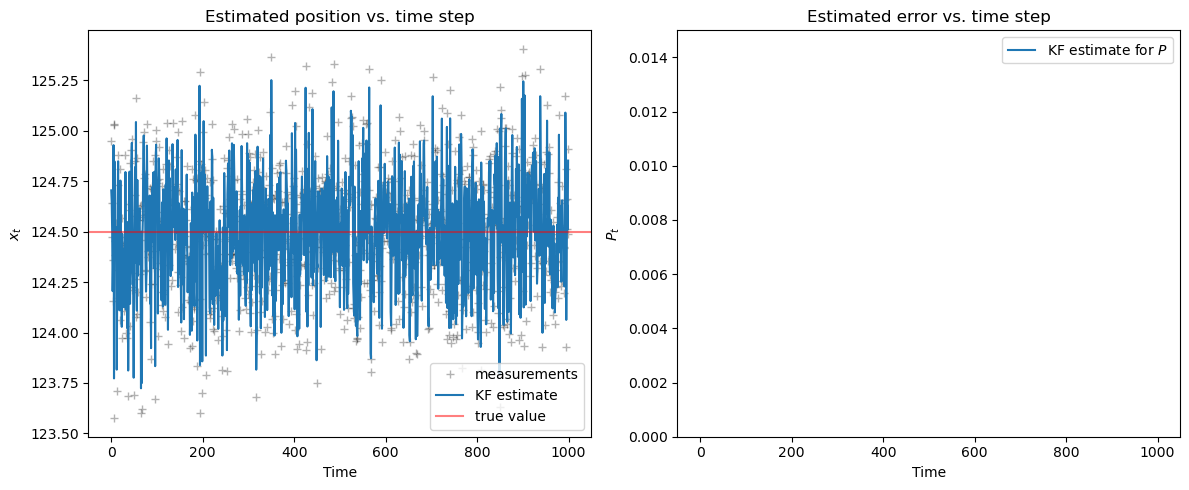

In [21]:
mu = 124.5 # Actual position
R = 0.1    # Actual standard deviation of actual measurements (R)

# Generate measurements
n_measurements = 1000 # Change the number of points to see how the convergence changes
Z = np.random.normal(mu, np.sqrt(R), size=n_measurements)

# initial guesses 
x = 123 # Use an integer (imagine the initial guess is determined with a meter stick)
P = 0.04 # error covariance P

KF_estimate=[] # To store the position estimate at each time point 
KF_error=[] # To store estimated error at each time point
for z in Z:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Z, KF_estimate, mu, axes[0])
plot_1d_error(KF_error, 0, 0.015, axes[1])
plt.tight_layout();


The KF does not converge to the true value.

- Since Q is the process noise covariance matrix, by assigning an high value to it we are essentially telling the KF to not trust the model.

This means that our kalman filter estimate will mostly rely on obtained measurements reather than prior values of the dynamic model. This is why the KF estimate heavly follows each noisy measurement without filtering out noise.

- Furthermore, the posterior covariance estimate P is always very close to zero. This is because, by setting the model noise much higher than the measurement noise, we are sayng that measurements are much more reliable than model prior prediction.

- The new KF looks more noisy than before because we set the Q value incorrectly. Since the true model has no perturbation (the true value of x is costant for all time instant) all the noise is itroduced by measurements. it would be ideal to set the model noise covariance to 0 to reject measurement noise as much as possible, since we know that the object is not actually moving.

By setting Q>>R we are essentially doing the opposite, that is to hypothize that the true values of x change rapidly and to heavly rely on measurement samples to correct the posterior estimate.

- As final proof let's try the opposite. Note how, by setting the Q = 0, the posterior stabilizes to the true value wihtout accounting for measurements at all.

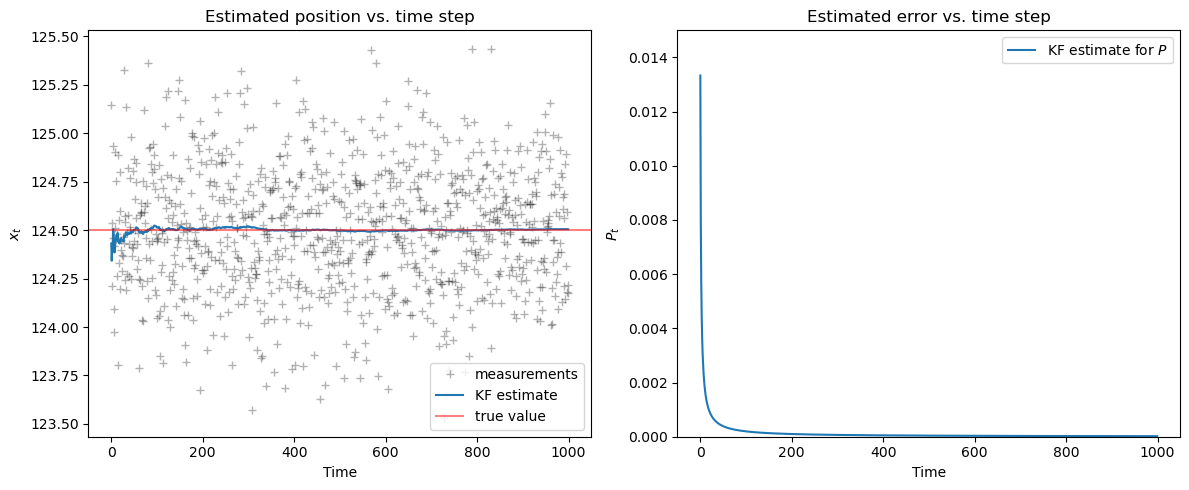

In [17]:
# Estimated covariances
Q_est = 0
R_est = 2e-2 
mu = 124.5 # Actual position
R = 0.1    # Actual standard deviation of actual measurements (R)

# Generate measurements
n_measurements = 1000 # Change the number of points to see how the convergence changes
Z = np.random.normal(mu, np.sqrt(R), size=n_measurements)

# initial guesses 
x = 123 # Use an integer (imagine the initial guess is determined with a meter stick)
P = 0.04 # error covariance P

KF_estimate=[] # To store the position estimate at each time point 
KF_error=[] # To store estimated error at each time point
for z in Z:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Z, KF_estimate, mu, axes[0])
plot_1d_error(KF_error, 0, 0.015, axes[1])
plt.tight_layout();

### Exercise #2

This exercise refers to [Example 2](#example-2-dynamic-one-dimensional-data). 

In the case we examined above, the KF estimate was close to the measurements and both were different from the true value.
Change the parameters of the algorithm until you find some combinations that achieve the following:

1. Measurements, KF estimate and true value are all close.
2. Measurements, KF estimate and true value are all noticeably different.
3. The measurements are close to the true value, but the KF estimate is different.

Discuss your findings.

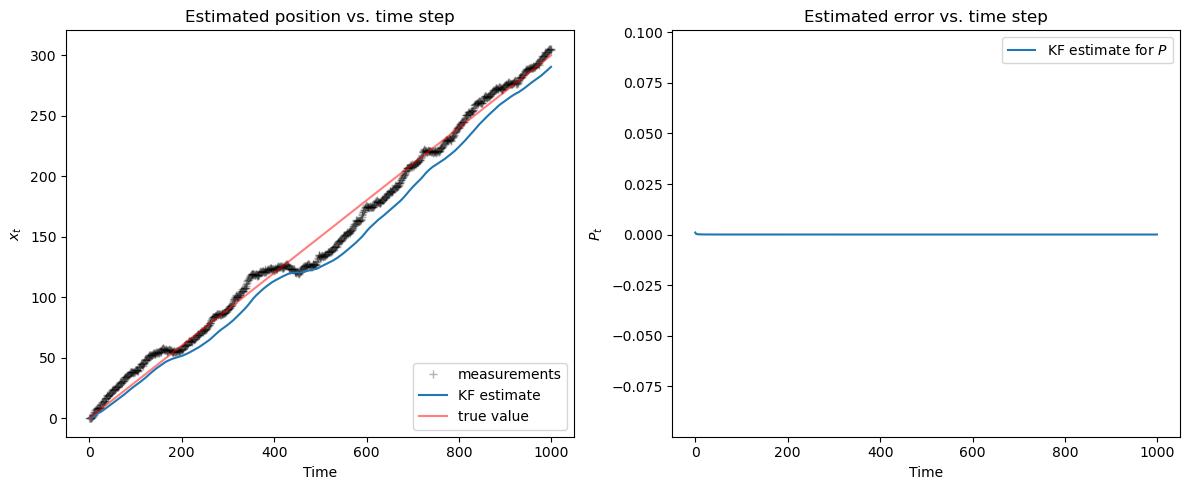

In [94]:
# initial parameters
v0 = 0.3 
x0 = 0.0     
R = 0.5

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R)) 
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements) 
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

# initial guesses and estimates
x = 0.5
P = 0.5
Q_est = 5e-7
R_est = 1e-3
KF_estimate = [] # To store the position estimate at each time point 
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.1, max(KF_error)+0.1, axes[1])
plt.tight_layout();


- First, let's make the measurements closer to the true positions. The true velocty is 0.3, but the default variance is 4. We need to tune the variance of the noise.
- With default values, the KF eavly follows measurement values. We ideally would like a good tradeoff between masurement and model stability, let's tune down Q and R, and keep Q < R such that the model don't stick too mach to the measurements.

Let's now address Point 2. To make all 3 values diffear from each other, we can use the following tactic:

1) Set the measurement noise to be high, such that measurements do not follow the true path anymore
2) Set Q to be very small. In this way, the KF will give low credit to measurement to update the state values, only trusting the model. In exercise 1, this approach was working sinche the true positions were constant. In this case, the KF need to use the informations about the measurements to follow the true path.



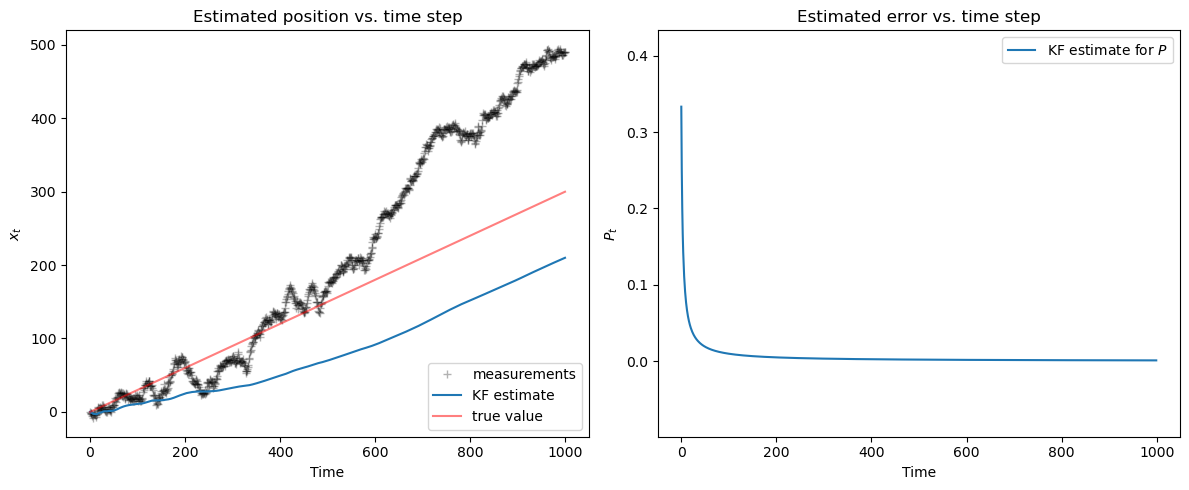

In [132]:
# initial parameters
v0 = 0.3 
x0 = 0.0     
R = 10

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R)) 
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements) 
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

# initial guesses and estimates
x = 0.5
P = 0.5
Q_est = 5e-10
R_est = 1
KF_estimate = [] # To store the position estimate at each time point 
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.1, max(KF_error)+0.1, axes[1])
plt.tight_layout();


For point 3:
- we need to keep the measurements close to the true path. to do so, let's tune down the nose error variance as in point 1.
- To keep the KF away from measurement and true path, just keep the Q low such that the KF does not follow themeasurement, as done in point 2.

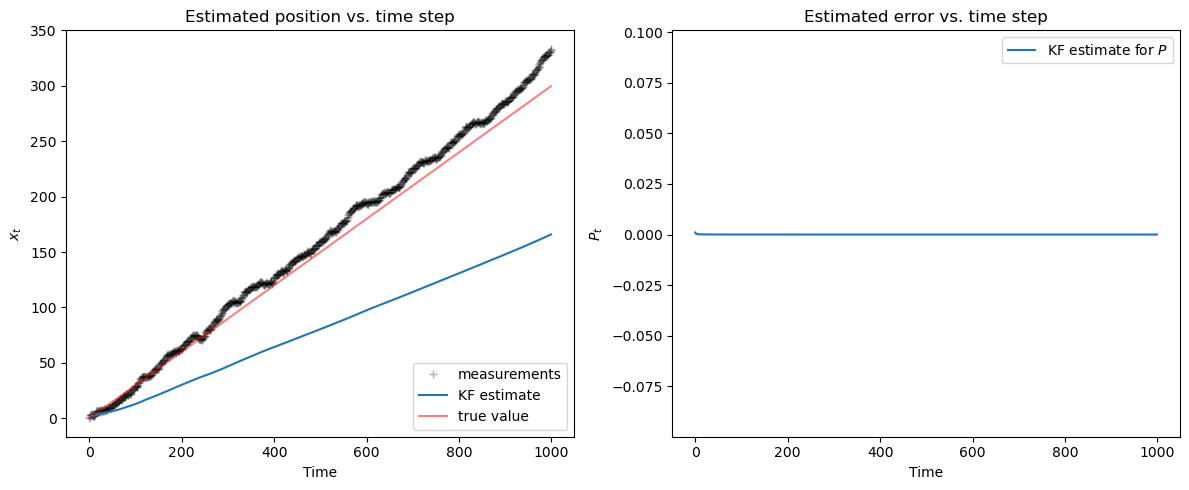

In [127]:
# initial parameters
v0 = 0.3 
x0 = 0.0     
R = 0.5

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R)) 
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements) 
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

# initial guesses and estimates
x = 0.5
P = 0.5
Q_est = 5e-10
R_est = 1e-3
KF_estimate = [] # To store the position estimate at each time point 
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.1, max(KF_error)+0.1, axes[1])
plt.tight_layout();


### Exercise #3

This exercise refers to [Example 3](#example-3-dynamic-two-dimensional-data). 

In the original example, we used both Position and Velocity (PV model) in the state vector, i.e., $\boldsymbol{x} = \begin{bmatrix} x & y & \dot x & \dot y \end{bmatrix}^T$. 

What happens if we use only the Position (P model) to describe the state? After all, our measurements only provide position. Do we really need to include the velocity?

1. Rewrite the algorithm above for the P model. 

**💡 Hint:** what is the size of the state vector in this case? What are the dimensions of the matrices that characterize the system?

To include only the position in the model, we need to update the dimension of all our matrices to exclude the velocity state variable. First, let's remove it from the state vector $x$:
-  $\boldsymbol{x} = \begin{bmatrix} x & y \end{bmatrix}^T$. 

We must also exclude the velocity form H and A:
- $\mathbf{A} = \begin{bmatrix} 1 & 0 \\ 0 & 1\\\end{bmatrix}$
- $\mathbf{H} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix}$

Also $Q$ Becomes a 2x2 diagonal matrix.



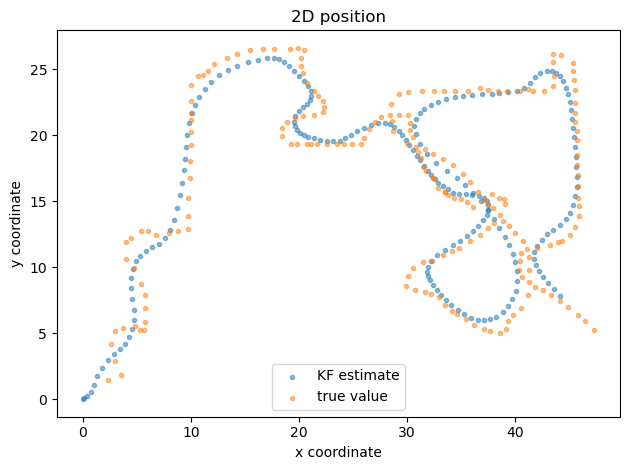

In [135]:
kalman = cv2.KalmanFilter(2,2,0) # 2 states, 2 measurements, 0 control vector

q = 1 # the variance in the model
r = 20 # the variance in the measurement
dtime = 1 # size of time step

kalman.measurementMatrix = np.array([[1,0],
                                     [0,1]],np.float32) #  H
kalman.transitionMatrix = np.array([[1,0,],
                                    [0,1,]],np.float32) # A
kalman.processNoiseCov = np.array([[1,0],
                                   [0,1]],np.float32) * q # Q
kalman.measurementNoiseCov = np.array([[1,0],
                                       [0,1]],np.float32) * r # R

KF_estimate_xy = [] # To store the position estimate at each time point

xy_motion = pd.read_csv('https://zenodo.org/records/10951538/files/kf_ts1.csv?download=1',
                        header = None).values.astype('float32')



for i in xy_motion:
    pred = kalman.predict()  # predicts new state using the model
    kalman.correct((i))      # updates estimated state with the measurement
    KF_estimate_xy.append(((pred[0]),(pred[1]))) # store the estimated position

x_est, y_est = zip(*KF_estimate_xy)
x_true, y_true = zip(*xy_motion)
plt.scatter(x_est, y_est, marker= '.', label = 'KF estimate', alpha = 0.5)
plt.scatter(x_true, y_true,marker= '.', label = 'true value', alpha = 0.5)
plt.legend(loc = 'lower center')
plt.title('2D position')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.tight_layout();

By excluding velocity from the state vector, the KF only react to positional changes without taking into account the model dynamocs. As shown above, the KF will still work but is less precise with respect to its version that includes velocity.